## Setup

In [298]:
import os
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
plt.rcParams['figure.figsize'] = (1920/90, 1080/90)
plt.rcParams['figure.dpi'] = 90
import colorsys
import math
from matplotlib.patches import Circle, Rectangle
import threading

In [305]:
# Config
# Hue range for test 50° - 150°
# Start: 3:21 -> 201 sec -> Frame 201 * 60
interval = 6
positions = {
        'dylan': {
        'full': [179, 1611],
        'part': [538, 1670]
    },
    'destiny':{
        'full': [179, 800],
        'part_left': [538, 950],
        'part_right': [538, 1050]
    },
    'haz': {
        'full': [900, 1100],
        'part': [900, 1300]
    },
    'hinkle': {
        'full': [900, 900],
        'part': [900, 650]
    },
    'moderator': {
        'full': [179, 300],
        'part': [538, 330]
    }
}

## Create Frames
- Add frames/ folder.
- Update video file name if necessary. 

In [ ]:
# LONG -- Skip this if you don't have the video file
preexistings = os.listdir("frames")

videoFile = "Y2Mate.is - Pro Putin Lefty SNAPS, Starts Fight w Destiny And Moderator-pqktQZT5W2w-1080p-1646408282750.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
print(frameRate)
frame_count = 0
while(cap.isOpened()):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
    ret, frame = cap.read()
    if (ret != True):
        break           
    filename = os.path.join("frames", "%d.jpg" % frame_count)
    cv2.imwrite(filename, frame)
    frame_count += interval
    c = 1
    while "%d.jpg" % frame_count in preexistings:
        c += 1
        frame_count += interval

cap.release()

print ("Done!")

## Example output
Where the mapping will be done from.
Checks are run not on single pixels but on an area (21x3) originating around the selected pixel

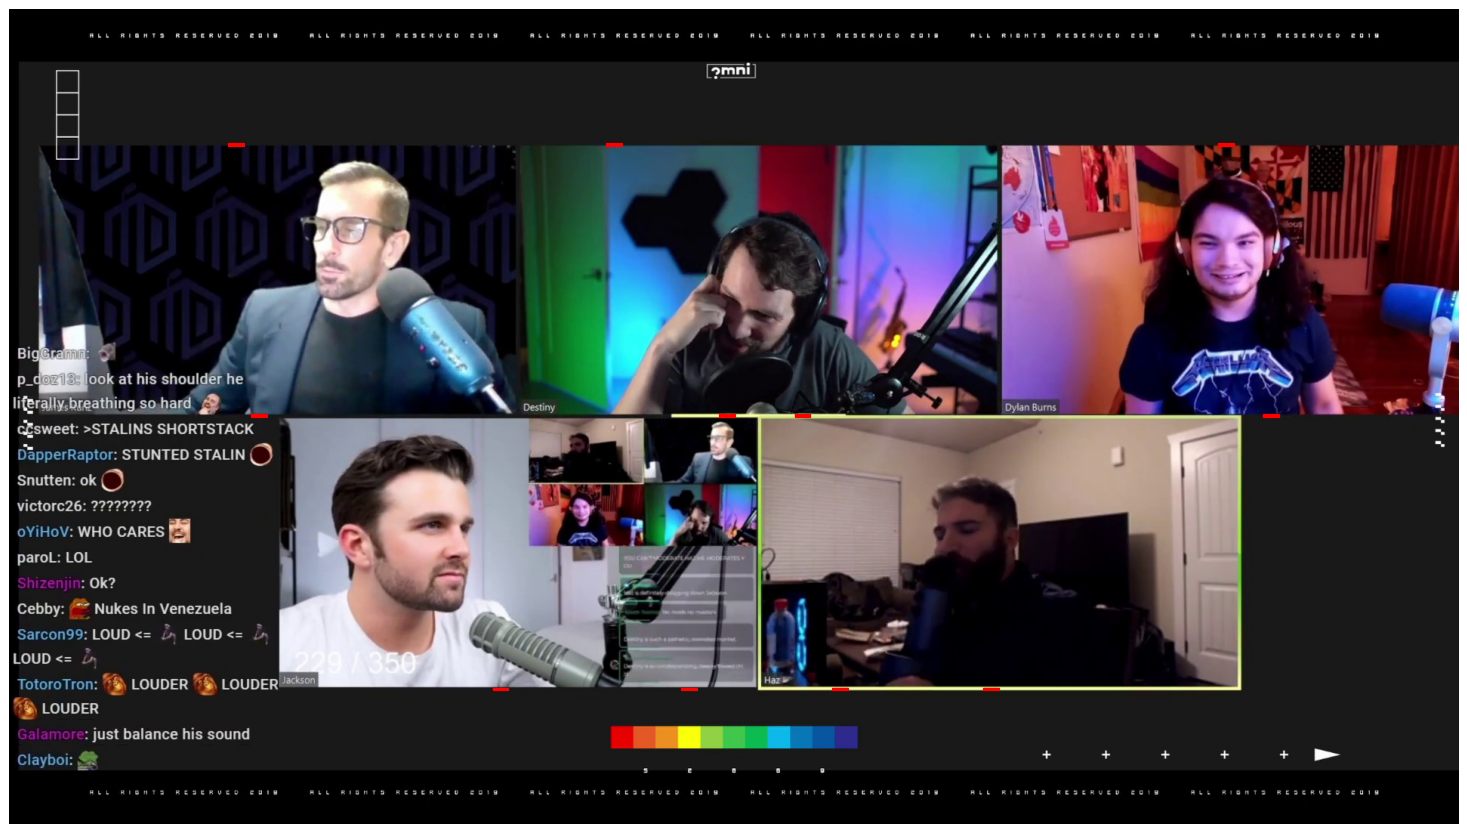

<Figure size 1920x1080 with 0 Axes>

In [306]:
# Example
patches = []
for participant in positions.values():
    for pos in participant.values():
        for x in range(-10, 11):
            for y in range(-1, 2):
                patches.append(Rectangle([pos[1] + x, pos[0] + y], 1, 1, color='red'))
    
img = plt.imread('frames/440472.jpg')
colors = img[540, 1650]
hsv = colorsys.rgb_to_hsv(*colors)
fig, ax = plt.subplots(1)
ax.imshow(img)
for p in patches:
    ax.add_patch(p)
plt.axis('off')
plt.figure(frameon=False)

plt.show(fig)

## Get colors at position
! slow

In [343]:
# SLOW RUNNING
frames = [int(frame.split(".")[0]) for frame in os.listdir("frames")]
frames = [frame for frame in frames if frame >= 201 * 60]
frames.sort()

def runner(outputfile):
    result = []
    failed = 0
    while frames:
        frame = frames.pop(0)
        line = [frame]
        try:
            img = plt.imread('frames/%s.jpg' % frame)
        except:
            #print("Failed:", failed, end="\r", flush=True); failed += 1
            continue
        for participant in positions.values():
            for pos in participant.values():
                cols = [0, 0, 0]
                count = 0
                for x in range(-10, 11):
                    for y in range(-1, 2):
                        pixel_color = img[pos[0] + y, pos[1] + x]
                        count += 1
                        for color in range(3):
                            cols[color] += pixel_color[color]
                avg = [col//count for col in cols]
                colors= "\"%s\"" % avg
                line.append(colors)
        outputfile.write(",".join([str(el) for el in line]) + "\n")
        if frame % 3600 == 0:
            print(frame, end="\r", flush=True)   
   
with open('output.csv', 'w+') as outputfile:
    header = ["frame"]
    for participant in positions:
        for pos in positions[participant]:
            header.append("%s_%s" % (participant, pos))
    outputfile.write(",".join(header) + "\n")
    runner(outputfile)
        


In [344]:
def is_active(colors):
    h, s, v = colorsys.rgb_to_hsv(*json.loads(colors))
    if (50 <= h * 360 <= 150) and v >= 50:
        return True
    return False

In [345]:
df = pd.read_csv('output.csv')
df.head()
for col in df.columns:
    if col == 'frame':
        continue
    df[col] = list(map(lambda x: is_active(x), df[col] ))
    
df["seconds"] = df["frame"] / 60
# cut off start
df = df[df["seconds"] >= 201]
print(df.shape)

# Destiny has 2 separate ranges for his "partially turned on mic" because it overlaps too heavily with Haz and Hinkel
# But only one frame can be turned on fully at any time so having both active at the same time means that Destinys mic is on

df["destiny_part"] = df['destiny_part_left'] & df['destiny_part_right']

for participant in positions.keys():
    df["%s_talking" % participant] = df["%s_full" % participant] | df["%s_part" % participant]

df[(df['frame'] >= 202020) & (df['frame'] <= 202620)].head(5)
talk_status = df[["%s_talking" % p for p in positions.keys()] + ["seconds", "frame"]].copy()
talk_status.head()

(73729, 13)


,dylan_talking,destiny_talking,haz_talking,hinkle_talking,moderator_talking,seconds,frame
0,False,False,False,False,True,201.0,12060
1,False,False,False,False,True,201.1,12066
2,False,False,False,False,True,201.2,12072
3,False,False,False,False,True,201.3,12078
4,False,False,False,False,True,201.4,12084


In [346]:
# Generate intervals
# Mic is marked as turned on from the first to the last consecutive frame.
# Individual intervals are then set up with a starting point (e.g. 133.1 seconds in) and a duration (e.g. 32.2 sec)

def assign_value(cols):
    print(cols)
for participant in positions.keys():
    
    talk_status[participant] = talk_status['%s_talking' % participant] * 1 #+ df['%s_part' % participant] * 0.5 Removed for now
    talk_status[participant] = list(map(lambda x: min(x, 1), talk_status[participant]))
    
full = talk_status[['seconds'] + list(positions.keys())].copy()
participants_full = {}

for participant in positions.keys():
    print(participant)
    results = full.copy()
    results["previous"] = results[participant].shift(1).fillna(0)
    results["next"] = results[participant].shift(-1).fillna(0)
    results["start"] = (results.previous == 0) & (results[participant] == 1)
    results["end"] = (results[participant] == 1) & (results.next == 0)
    results["one-frame"] = results.start & results.end # Start + End same frame
    del results["previous"]
    del results["next"]
    results = results[results.start | results.end]
    results["next_seconds"] = results.seconds.shift(-1)
    results = results[results.start & (results.end != True)]
    results["duration"] = results.next_seconds - results.seconds
    participants_full[participant] = results[["seconds", "duration"]].copy()
    print(participants_full[participant].head())

dylan
       seconds  duration
6373     838.3     285.7
9429    1143.9       0.3
9434    1144.4       0.6
9511    1152.1      12.8
10161   1217.1       4.3
destiny
      seconds  duration
4818    682.8     155.4
9231   1124.1      14.1
9378   1138.8       5.4
9435   1144.5       0.5
9483   1149.3       6.7
haz
       seconds  duration
18       202.8     116.6
9361    1137.1       8.3
9640    1165.0       1.9
9663    1167.3       5.1
10313   1232.3       2.7
hinkle
       seconds  duration
1185     319.5     331.7
11640   1365.0      31.0
11966   1397.6       3.9
12008   1401.8      68.4
12738   1474.8       2.7
moderator
      seconds  duration
0       201.0       1.7
1359    336.9       0.1
2615    462.5       1.8
2658    466.8       0.6
4503    651.3      31.4


## Graphs
- Broken up bar chart for who talked when (A Gantt chart just with multiple elements in a single row)
- Normal Bar + Pie Chart just for overall talk time

<Figure size 1920x1080 with 0 Axes>

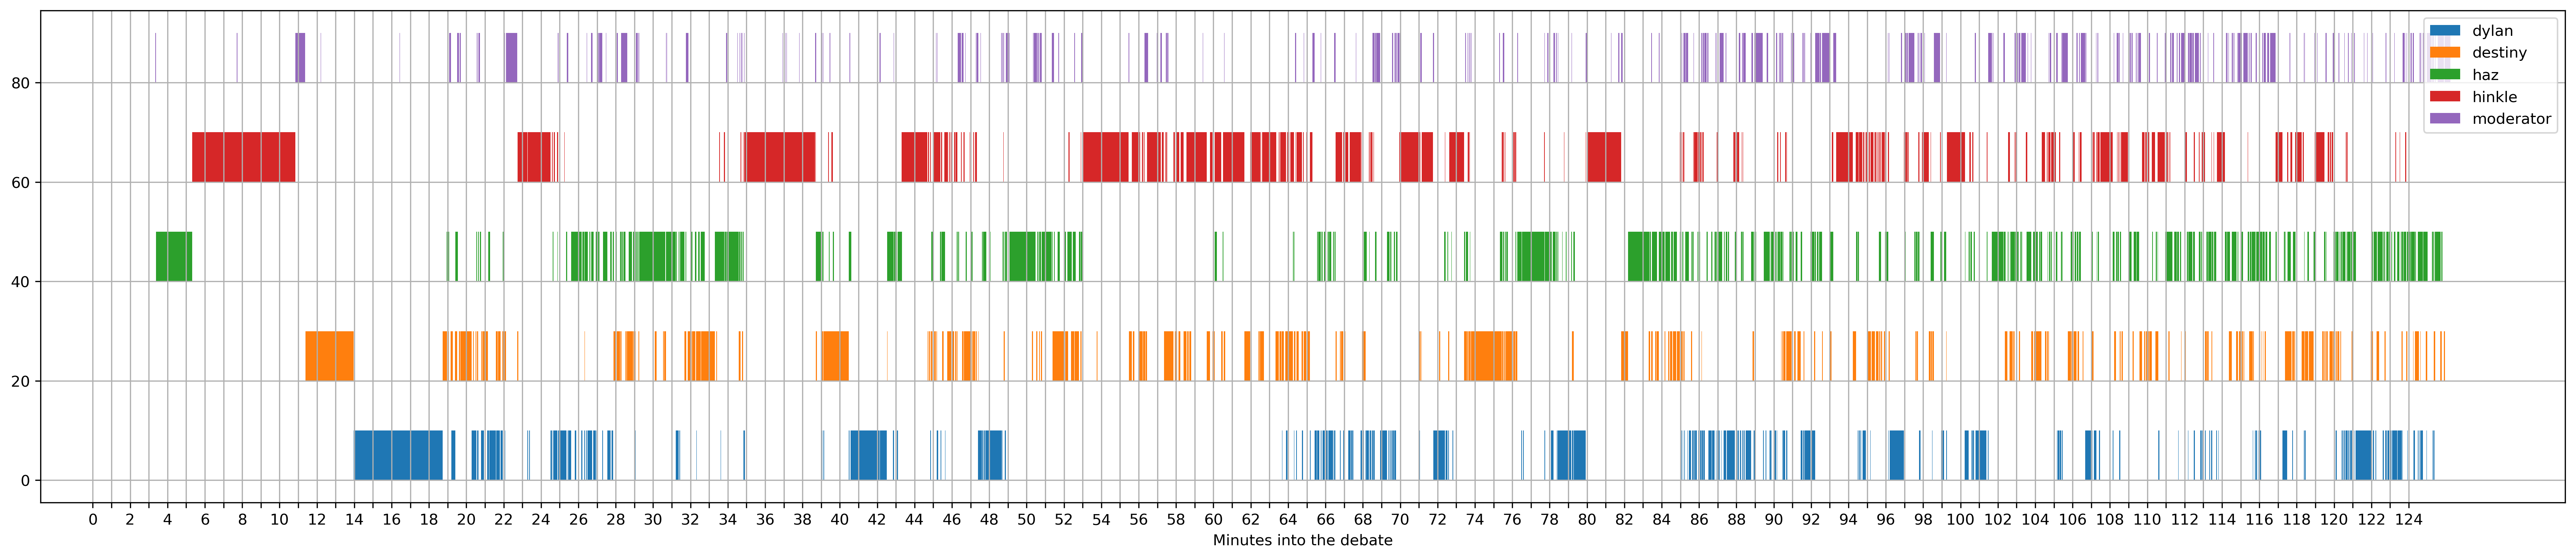

In [347]:
# Generating graph
plt.figure(figsize=(240, 135), dpi=8)
fig, ax = plt.subplots(figsize=(30, 6), dpi=300)
ax.grid(True)
ax.set_xlabel('Minutes into the debate')
ax.set_xticks([i*60 for i in range(0, 125)])
ax.set_xticklabels([i if i%2 == 0 else '' for i in range(0, 125)])


for index, participant in enumerate(positions.keys()):
    data = participants_full[participant].copy()
    data = list(zip(data.seconds.values, data.duration.values))
    data = [entry for entry in data if entry[1] > 5/60]
    ax.broken_barh(data, (index * 20, 10), label=participant, color="C%d" % index, edgecolor=None)
    
plt.legend(labels=["dylan", "destiny", "haz", "hinkle", "moderator"])


In [348]:
approx = []
for participant in participants_full:
    approx.append(sum(participants_full[participant].duration.values)/60)
approx

[28.106666666665685,
 30.023333333332438,
 36.749999999998835,
 41.454999999999146,
 18.17333333333209]

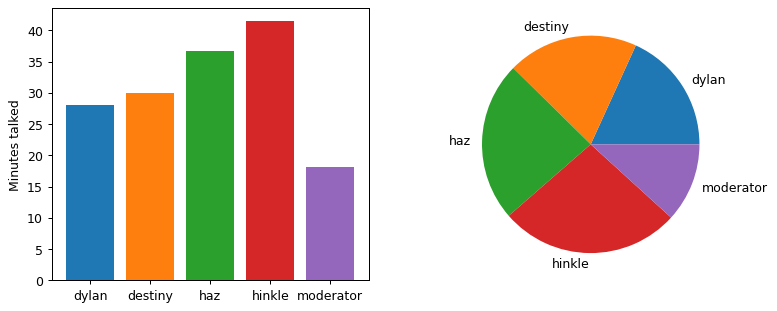

In [349]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4),)
for i in range(5):
    ax1.bar(i, approx[i], color="C%s" % i, label=list(participants_full.keys())[i])
ax1.set_xticklabels([None] + list(participants_full.keys()))
ax1.set_ylabel("Minutes talked")
ax2.pie(approx, labels=list(participants_full.keys()), colors=["C%d" % i for i in range(5)])

plt.show()